# House Price Prediction (Advanced): Keras, PyTorch, and JAX

This notebook attempts new strategies to stabilize PyTorch/JAX:
1. **Three hidden layers** (256 → 128 → 64) with dropout.
2. **Two-phase training**:
   - Phase 1: Train MSE only (10 epochs).
   - Phase 2: Train MSE + KL (40 epochs).
3. **Lower KL alpha** (`1e-4`).
4. **Lower LR** in PyTorch/JAX (`1e-4`).
5. **Random seeds** set for each framework.

We use the same data preprocessing (fill missing values, log(SalePrice), top 3 features + random interaction).

## Mathematical Explanation

- **Phase 1**: Loss = MSE(log(SalePrice)).
- **Phase 2**: Loss = MSE + alpha * KL.
  - We compute KL between the soft histograms of log(y_true) and log(y_pred).
  - alpha = 1e-4.

By training first with MSE only, we let the model settle on a stable scale. Then we add KL to shape the distribution.

In [1]:
pip install tensorflow pytorch jax flax

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-pub4vchm/pytorch_28613ba869ee419e8470c0709385a5f3/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable whe

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# JAX / Flax / Optax
import jax
import jax.numpy as jnp
import flax.linen as nn_flax
from flax.training import train_state
import optax

print('TensorFlow version:', tf.__version__)
print('Torch version:', torch.__version__)
print('JAX version:', jax.__version__)

%matplotlib inline

2025-02-25 11:24:39.155950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 11:24:41.089557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 11:24:41.281681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740482681.524538    3197 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740482681.630383    3197 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 11:24:42.134805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

TensorFlow version: 2.18.0
Torch version: 2.5.1+cpu
JAX version: 0.5.0


## 1. Load and Preprocess Data

Fill missing values in train and test, log-transform SalePrice, select top 3 features, add random interaction. We'll set seeds for reproducibility.

In [3]:
# Set seeds for reproducibility
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
rng_jax = jax.random.PRNGKey(42)

# File paths
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

def fill_missing_values(df):
    num_cols = df.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Fill missing in train
train_df = fill_missing_values(train_df.copy())

# Log transform
y = np.log(train_df['SalePrice'])
X = train_df.drop(['Id','SalePrice'], axis=1)
X = pd.get_dummies(X, drop_first=True)
print('Initial X shape:', X.shape)


Train shape: (1000, 81)
Test shape: (460, 80)
Initial X shape: (1000, 230)


/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

### 1.1 Top 3 Features + Random Interaction

In [4]:
temp_df = train_df.select_dtypes(include=[np.number])
corr_matrix = temp_df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:4].index.tolist()
print('Top 3 features:', top_features)

X = X[top_features]
print('X shape after top-3:', X.shape)

if len(top_features) >= 2:
    f1, f2 = top_features[0], top_features[1]
    X['RandomInteraction'] = X[f1]*X[f2]
    print('Added RandomInteraction feature:', f1, '*', f2)
    print('New X shape:', X.shape)

Top 3 features: ['OverallQual', 'GrLivArea', 'GarageCars']
X shape after top-3: (1000, 3)
Added RandomInteraction feature: OverallQual * GrLivArea
New X shape: (1000, 4)


### 1.2 Train-Validation Split and Scaling

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 4)
X_val_scaled shape: (200, 4)


## 2. Keras/TensorFlow
We do a 3-layer network: 256 → 128 → 64. **Two-phase** training:
1. 10 epochs MSE only
2. 40 epochs MSE + KL

In [6]:
def soft_histogram_tf_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = tf.concat([y_true, y_pred], axis=0)
    min_val = tf.reduce_min(combined)
    max_val = tf.reduce_max(combined)
    bin_centers = tf.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        vals = tf.reshape(vals, [-1,1])
        diff = vals - bin_centers
        soft_counts = tf.exp(-tf.square(diff)/(2.0*sigma**2))
        hist = tf.reduce_sum(soft_counts, axis=0)
        hist = hist / tf.reduce_sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def kl_divergence_tf(y_true, y_pred, alpha=1e-4):
    hist_true, hist_pred = soft_histogram_tf_both(y_true, y_pred)
    epsilon = 1e-6
    hist_true = tf.clip_by_value(hist_true, epsilon, 1.0)
    hist_pred = tf.clip_by_value(hist_pred, epsilon, 1.0)
    kl = tf.reduce_sum(hist_true * tf.math.log(hist_true/hist_pred))
    return alpha*kl

def mse_only_tf(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mse_plus_kl_tf(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    kl = kl_divergence_tf(y_true, y_pred, alpha=1e-4)
    return mse + kl

# Build Keras model
model_keras = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_keras.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 11:24:57.895701: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,497 (166.00 KB)

 Trainable params: 42,497 (166.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Phase 1: 10 epochs MSE only
model_keras.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=mse_only_tf
)
history_1 = model_keras.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Phase 2: 40 epochs MSE + KL
model_keras.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=mse_plus_kl_tf
)
history_2 = model_keras.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 121.3896 - val_loss: 30.4577
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.4097 - val_loss: 17.1324
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9294 - val_loss: 7.3807
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9903 - val_loss: 4.5602
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2230 - val_loss: 2.4224
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6210 - val_loss: 1.7214
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5930 - val_loss: 1.5900
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8065 - val_loss: 0.9343
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6453 - val_loss: 0.6209
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5557 - val_loss: 0.3925
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5719 - val_loss: 0.3452
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

### Keras Evaluation
We combine the history from Phase 1 + Phase 2, then plot. Also plot actual vs. predicted distribution.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Keras Validation RMSE: 30101.373738695904


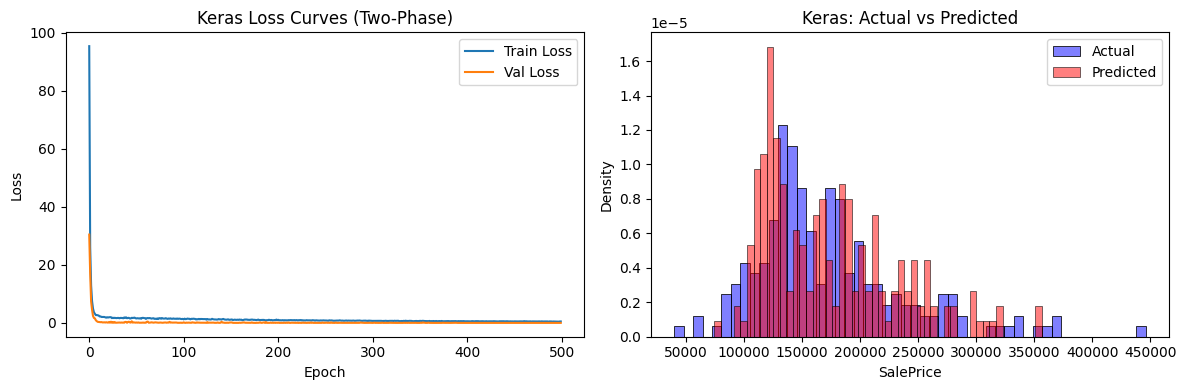

In [8]:
# Combine history
loss_keras = history_1.history['loss'] + history_2.history['loss']
val_loss_keras = history_1.history['val_loss'] + history_2.history['val_loss']

y_val_pred_log_keras = model_keras.predict(X_val_scaled).flatten()
y_val_pred_keras = np.exp(y_val_pred_log_keras)
y_val_actual_keras = np.exp(y_val)

rmse_keras = np.sqrt(mean_squared_error(y_val_actual_keras, y_val_pred_keras))
print('Keras Validation RMSE:', rmse_keras)

# Plot Keras loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_keras, label='Train Loss')
plt.plot(val_loss_keras, label='Val Loss')
plt.title('Keras Loss Curves (Two-Phase)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Keras distribution
plt.subplot(1,2,2)
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.title('Keras: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### Keras: Save Test Predictions

In [9]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)

test_preds_log_keras = model_keras.predict(test_scaled).flatten()
test_preds_keras = np.exp(test_preds_log_keras)

predictions_keras = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_keras})
predictions_keras.to_csv('predictions_keras_KL_v6.csv', index=False)
print('Keras predictions saved to predictions_keras_KL_v6.csv')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Keras predictions saved to predictions_keras_KL_v6.csv


/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 3. PyTorch
We do the same 3-layer net, two-phase training (MSE only then MSE+KL), alpha=1e-4, LR=1e-4 to reduce divergence.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class HousePriceNetTorch(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNetTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

def soft_histogram_torch_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = torch.cat([y_true, y_pred], dim=0)
    min_val = torch.min(combined)
    max_val = torch.max(combined)
    bin_centers = torch.linspace(min_val, max_val, steps=num_bins, device=y_true.device)

    def compute_hist(vals):
        vals = vals.view(-1,1)
        diff = vals - bin_centers.view(1,-1)
        soft_counts = torch.exp(- (diff**2)/(2*sigma**2))
        hist = torch.sum(soft_counts, dim=0)
        hist = hist / torch.sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def mse_only_torch(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

def mse_plus_kl_torch(y_true, y_pred):
    mse = torch.mean((y_true - y_pred)**2)
    hist_true, hist_pred = soft_histogram_torch_both(y_true, y_pred, 50, 1.0)
    epsilon = 1e-6
    hist_true = torch.clamp(hist_true, min=epsilon, max=1.0)
    hist_pred = torch.clamp(hist_pred, min=epsilon, max=1.0)
    kl = torch.sum(hist_true * torch.log(hist_true/hist_pred))
    alpha = 1e-4
    return mse + alpha*kl

model_torch = HousePriceNetTorch(X_train_scaled.shape[1]).to(device)
print(model_torch)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1).to(device)

# Phase 1: MSE only
optimizer_pt = optim.Adam(model_torch.parameters(), lr=1e-4)
train_losses_pt_phase1 = []
val_losses_pt_phase1 = []
num_epochs_phase1 = 100

for epoch in range(num_epochs_phase1):
    model_torch.train()
    optimizer_pt.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = mse_only_torch(y_train_tensor, outputs)
    loss.backward()
    optimizer_pt.step()
    train_losses_pt_phase1.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = mse_only_torch(y_val_tensor, val_outputs)
        val_losses_pt_phase1.append(val_loss.item())

# Phase 2: MSE + KL
train_losses_pt_phase2 = []
val_losses_pt_phase2 = []
num_epochs_phase2 = 400

for epoch in range(num_epochs_phase2):
    model_torch.train()
    optimizer_pt.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = mse_plus_kl_torch(y_train_tensor, outputs)
    loss.backward()
    optimizer_pt.step()
    train_losses_pt_phase2.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = mse_plus_kl_torch(y_val_tensor, val_outputs)
        val_losses_pt_phase2.append(val_loss.item())


Using device: cpu
HousePriceNetTorch(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


### PyTorch Evaluation

PyTorch Validation RMSE: 3353438.3448061184


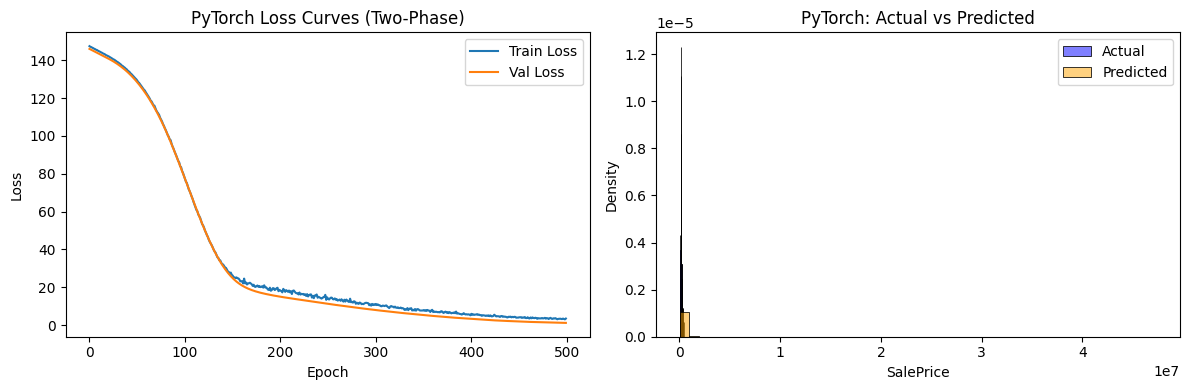

In [11]:
pt_losses = train_losses_pt_phase1 + train_losses_pt_phase2
pt_val_losses = val_losses_pt_phase1 + val_losses_pt_phase2

model_torch.eval()
with torch.no_grad():
    val_preds_pt_log = model_torch(X_val_tensor).cpu().numpy().flatten()

val_preds_pt = np.exp(val_preds_pt_log)
y_val_actual_pt = np.exp(y_val_tensor.cpu().numpy().flatten())
rmse_torch = np.sqrt(mean_squared_error(y_val_actual_pt, val_preds_pt))
print('PyTorch Validation RMSE:', rmse_torch)

# Plot PyTorch
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(pt_losses, label='Train Loss')
plt.plot(pt_val_losses, label='Val Loss')
plt.title('PyTorch Loss Curves (Two-Phase)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_pt, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.5, stat='density', label='Predicted')
plt.title('PyTorch: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### PyTorch: Save Test Predictions

In [12]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

model_torch.eval()
with torch.no_grad():
    test_preds_pt_log = model_torch(test_tensor).cpu().numpy().flatten()
test_preds_pt = np.exp(test_preds_pt_log)

predictions_torch = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_pt})
predictions_torch.to_csv('predictions_pytorch_KL_v6.csv', index=False)
print('PyTorch predictions saved to predictions_pytorch_KL_v6.csv')

PyTorch predictions saved to predictions_pytorch_KL_v6.csv


/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 4. JAX (Flax + Optax)
Same 3-layer net, alpha=1e-4, two-phase training with a lower LR (1e-4).

In [16]:
class HousePriceNetJAX(nn_flax.Module):
    dropout_rate: float = 0.2

    @nn_flax.compact
    def __call__(self, x, training):
        x = nn_flax.Dense(256)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(128)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(64)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(1)(x)
        return x

model_jax = HousePriceNetJAX()
dummy_input = jnp.ones((X_train_scaled.shape[0], X_train_scaled.shape[1]))
params_jax = model_jax.init(rng_jax, dummy_input, training=True)['params']
print('JAX model params init.')

class TrainState(train_state.TrainState):
    pass

def soft_histogram_jax_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = jnp.concatenate([y_true, y_pred])
    min_val = jnp.min(combined)
    max_val = jnp.max(combined)
    bin_centers = jnp.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        vals = vals.reshape(-1,1)
        diff = vals - bin_centers
        sc = jnp.exp(- (diff**2)/(2*sigma**2))
        hist = jnp.sum(sc, axis=0)
        hist = hist / jnp.sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def mse_only_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    return jnp.mean((preds - targets)**2)

def mse_plus_kl_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    mse = jnp.mean((preds - targets)**2)
    hist_true, hist_pred = soft_histogram_jax_both(jnp.ravel(targets), jnp.ravel(preds))
    epsilon = 1e-6
    hist_true = jnp.clip(hist_true, epsilon, 1.0)
    hist_pred = jnp.clip(hist_pred, epsilon, 1.0)
    kl = jnp.sum(hist_true * jnp.log(hist_true/hist_pred))
    alpha = 1e-4
    return mse + alpha*kl

def create_train_state_jax(params):
    tx = optax.adam(1e-4)
    return TrainState.create(apply_fn=model_jax.apply, params=params, tx=tx)

state_jax = create_train_state_jax(params_jax)
print('JAX train state created.')

@jax.jit
def train_step_jax_phase1(state, batch, rng):
    # Phase 1: MSE only
    def loss_fn(params):
        return mse_only_jax(params, batch, rng, True)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def train_step_jax_phase2(state, batch, rng):
    # Phase 2: MSE + KL
    def loss_fn(params):
        return mse_plus_kl_jax(params, batch, rng, True)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


@jax.jit
def eval_step_jax_phase1(params, batch, rng):
    # Phase 1: MSE only
    return mse_only_jax(params, batch, rng, False)

@jax.jit
def eval_step_jax_phase2(params, batch, rng):
    # Phase 2: MSE + KL divergence
    return mse_plus_kl_jax(params, batch, rng, False)


X_train_jax = jnp.array(X_train_scaled)
y_train_jax = jnp.array(y_train.values).reshape(-1,1)
X_val_jax = jnp.array(X_val_scaled)
y_val_jax = jnp.array(y_val.values).reshape(-1,1)

num_epochs_jax_phase1 = 100
num_epochs_jax_phase2 = 400
train_losses_jax_phase1 = []
val_losses_jax_phase1 = []
train_losses_jax_phase2 = []
val_losses_jax_phase2 = []

# Phase 1 (MSE only)
for epoch in range(num_epochs_jax_phase1):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (X_train_jax, y_train_jax)
    state_jax, loss = train_step_jax_phase1(state_jax, batch_train, step_rng)
    train_losses_jax_phase1.append(loss.item())

    val_loss = eval_step_jax_phase1(state_jax.params, (X_val_jax, y_val_jax), step_rng)
    val_losses_jax_phase1.append(val_loss.item())

# Phase 2 (MSE + KL)
for epoch in range(num_epochs_jax_phase2):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (X_train_jax, y_train_jax)
    state_jax, loss = train_step_jax_phase2(state_jax, batch_train, step_rng)
    train_losses_jax_phase2.append(loss.item())

    val_loss = eval_step_jax_phase2(state_jax.params, (X_val_jax, y_val_jax), step_rng)
    val_losses_jax_phase2.append(val_loss.item())


JAX model params init.
JAX train state created.


### JAX Evaluation
We combine Phase 1 + Phase 2 losses.

JAX Validation RMSE: 1107080933559.904


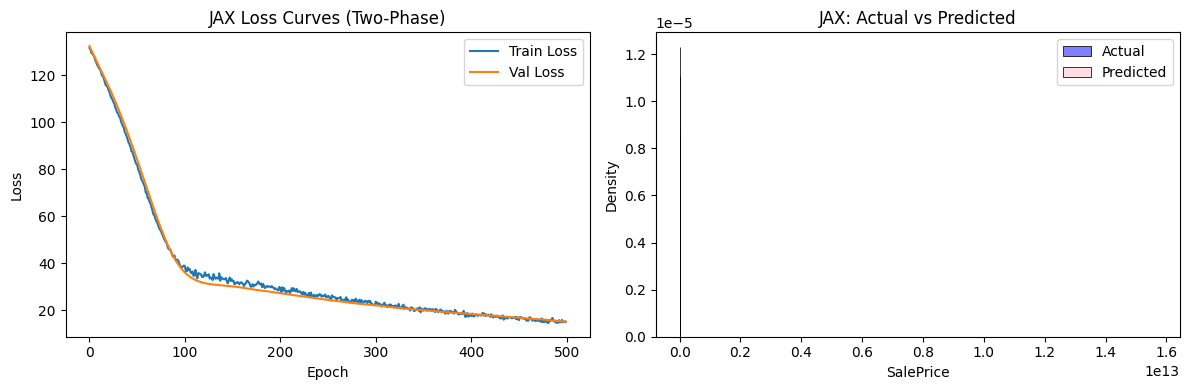

In [17]:
jax_losses = train_losses_jax_phase1 + train_losses_jax_phase2
jax_val_losses = val_losses_jax_phase1 + val_losses_jax_phase2

preds_val_log_jax = model_jax.apply({'params': state_jax.params}, X_val_jax, training=False, rngs={'dropout': rng_jax})
preds_val_log_jax = np.array(preds_val_log_jax).flatten()
val_preds_jax = np.exp(preds_val_log_jax)
y_val_actual_jax = np.exp(y_val_jax.flatten())

rmse_jax = np.sqrt(mean_squared_error(y_val_actual_jax, val_preds_jax))
print('JAX Validation RMSE:', rmse_jax)

# Plot JAX
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(jax_losses, label='Train Loss')
plt.plot(jax_val_losses, label='Val Loss')
plt.title('JAX Loss Curves (Two-Phase)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_jax, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.5, stat='density', label='Predicted')
plt.title('JAX: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### JAX: Save Test Predictions

In [18]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_jax = jnp.array(test_scaled)

test_preds_log_jax = model_jax.apply({'params': state_jax.params}, test_jax, training=False, rngs={'dropout': rng_jax})
test_preds_log_jax = np.array(test_preds_log_jax).flatten()
test_preds_jax = np.exp(test_preds_log_jax)

predictions_jax = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_jax})
predictions_jax.to_csv('predictions_jax_KL_v6.csv', index=False)
print('JAX predictions saved to predictions_jax_KL_v6.csv')

/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3197/335241533.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

JAX predictions saved to predictions_jax_KL_v6.csv


/tmp/ipykernel_3197/2198655415.py:11: RuntimeWarning: overflow encountered in exp
  test_preds_jax = np.exp(test_preds_log_jax)


## 5. Compare Final RMSE

In [19]:
print('Keras RMSE:', rmse_keras)
print('PyTorch RMSE:', rmse_torch)
print('JAX RMSE:', rmse_jax)

Keras RMSE: 30101.373738695904
PyTorch RMSE: 3353438.3448061184
JAX RMSE: 1107080933559.904


Keras RMSE: 30101.373738695904
PyTorch RMSE: 3353438.3448061184
JAX RMSE: 1107080933559.904


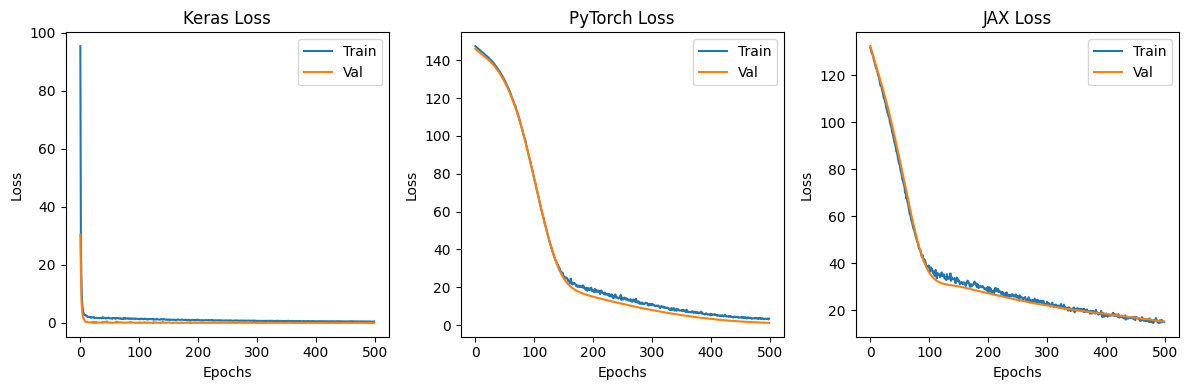

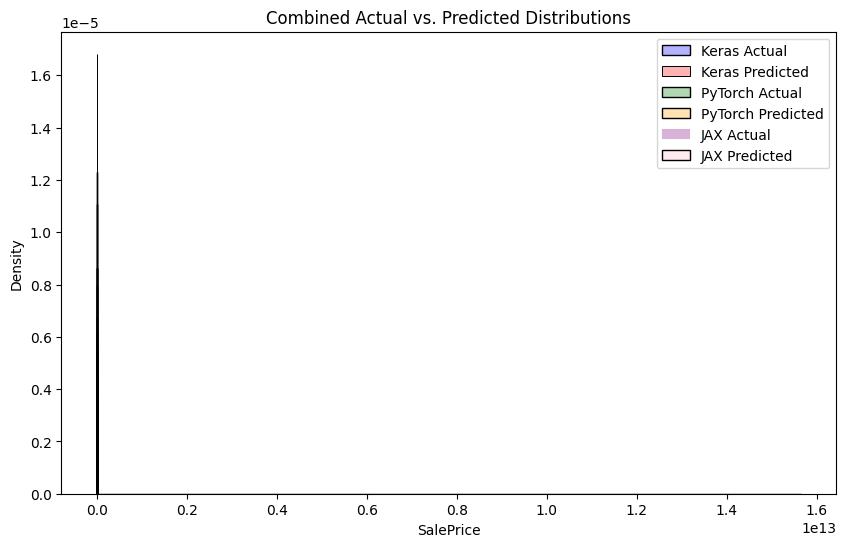

In [23]:
# Print summary RMSE values
print("Keras RMSE:", rmse_keras)
print("PyTorch RMSE:", rmse_torch)
print("JAX RMSE:", rmse_jax)

# Plot combined loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(loss_keras, label='Train')
plt.plot(val_loss_keras, label='Val')
plt.title('Keras Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(pt_losses, label='Train')
plt.plot(pt_val_losses, label='Val')
plt.title('PyTorch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(jax_losses, label='Train')
plt.plot(jax_val_losses, label='Val')
plt.title('JAX Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.legend()
plt.show()

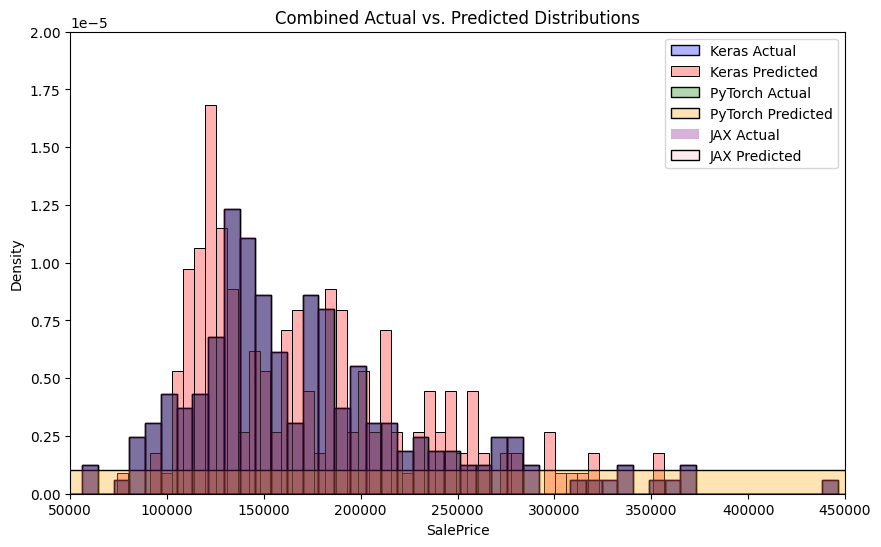

In [24]:
# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.xlim(50000, 450000)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()


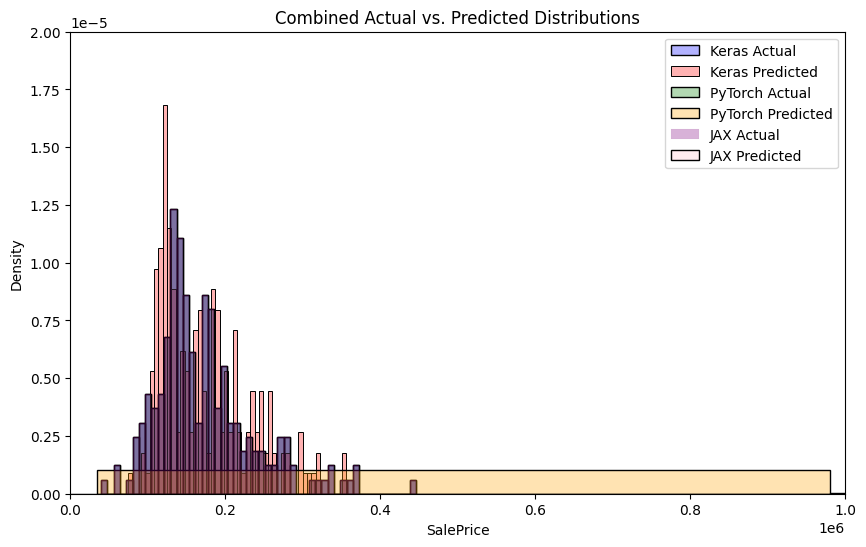

In [25]:
# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.xlim(0, 1e6)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()


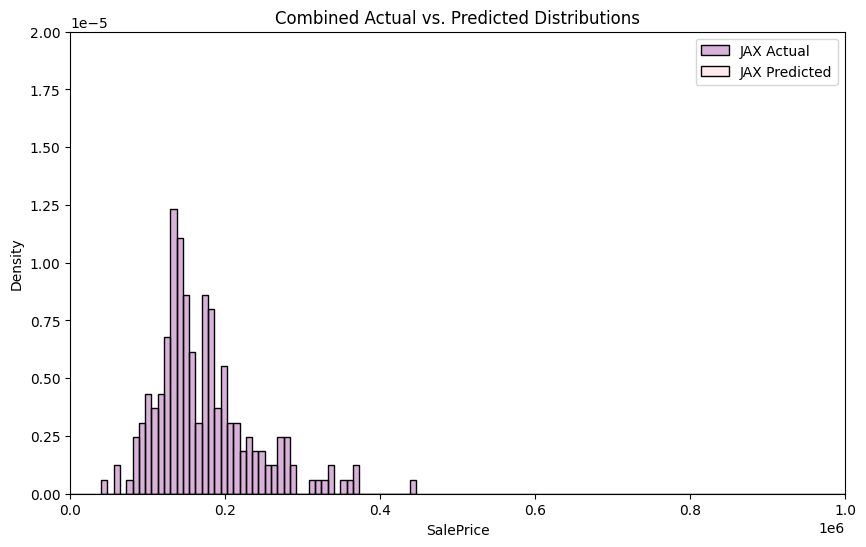

In [31]:
# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.xlim(0, 1e6)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()


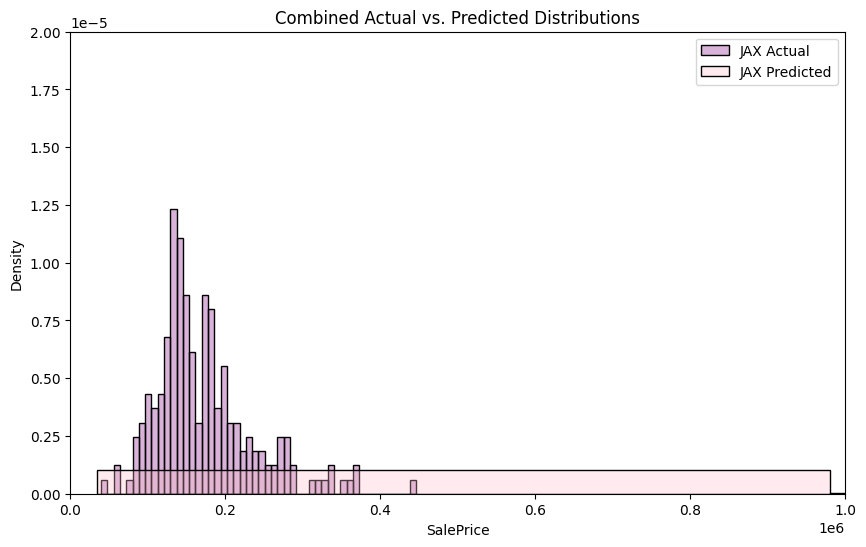

In [27]:
# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))

sns.histplot(y_val_actual_pt, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_pt, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.xlim(0, 1e6)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()
